# Panelled radiation pressure sattelite propagation

Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.


## Context

GRAIL (Gravity Recovery and Interior Laboratory) was a mission performed by NASA late 2011 and early 2012 its goal was to map the gravity field of the Moon. Two spacecraft where launched (GRAIL-A and GRAIL-B) they where launched into the same lunar orbit and measured the position between each other very accuratly. Using the variation in this distance the lunar gravity field can be inferred. See *T. L. Hoffman, "GRAIL: Gravity mapping the moon," 2009 IEEE Aerospace conference, Big Sky, MT, USA, 2009, pp. 1-8, doi: 10.1109/AERO.2009.4839327* for more information.

In order to infer information about the Moon's gravity field from the measurements of GRAIL-A and GRAIL-B all other accelerations have to be accounted for. This example will focus on how the solar radiation pressure can be modeled using tudat.




In [6]:

# Load standard modules
import numpy as np
import sys
import os
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment_setup, propagation_setup
from tudatpy.astro import element_conversion
from tudatpy.util import result2array
from tudatpy.astro.time_conversion import DateTime

# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
simulation_start_epoch = DateTime(2012, 4, 2).epoch() 
simulation_end_epoch   = simulation_start_epoch + 2.0 * 24 * 60**2

# Define string names for bodies to be created from default.
bodies_to_create = ["Sun", "Moon"]

# Use "Earth"/"J2000" as global frame origin and orientation.
global_frame_origin = "Moon"
global_frame_orientation = "ECLIPJ2000"

# Create default body settings, usually from `spice`.
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation)

## Create spacecraft body

We will first add an empty body to the body settings and start reading the relevant data from files containing information about the spacecraft panels.

In [7]:

# Create settings for the GRAIL A satellite (initialize an empty settings object to which we will add the vehicle shape and mass information)
body_settings.add_empty_settings("GRAIL_A")

# Read the panel data from input files
this_file_path = os.getcwd()
panel_data = pd.read_csv(this_file_path + "/input/grail_macromodel.txt", delimiter=", ", engine="python")
material_data = pd.read_csv(this_file_path + "/input/grail_materials.txt", delimiter=", ", engine="python")

Loop over all 

In [8]:
# initialize list to store all panel settings
all_panel_settings = []

for i, row in panel_data.iterrows():
    # create panel geometry settings
    # Options are: frame_fixed_panel_geometry, time_varying_panel_geometry, body_tracking_panel_geometry
    panel_geometry_settings = environment_setup.vehicle_systems.frame_fixed_panel_geometry(
        np.array([row["x"], row["y"], row["z"]]), # panel position in body reference frame
        row["area"] # panel area
    )    
    
    panel_material_data = material_data[material_data["material"] == row["material"]]
        
    # create panel radiation settings (for specular and diffuse reflection)
    specular_diffuse_body_panel_reflection_settings = environment_setup.radiation_pressure.specular_diffuse_body_panel_reflection(
        specular_reflectivity=float(panel_material_data["Cs"].iloc[0]), diffuse_reflectivity=float(panel_material_data["Cd"].iloc[0]), with_instantaneous_reradiation=True
    )
    
    # create settings for complete pannel (combining geometry and material properties relevant for radiation pressure calculations)
    complete_panel_settings = environment_setup.vehicle_systems.body_panel_settings(
        panel_geometry_settings,
        specular_diffuse_body_panel_reflection_settings
    )
    
    # add panel settings to list of all panel settings
    all_panel_settings.append(
        complete_panel_settings
    )

# Create settings object for complete vehicle shape
full_panelled_body_settings = environment_setup.vehicle_systems.full_panelled_body_settings(
    all_panel_settings
)

## Apply vehicle settings
Now the settings are applied to the GRAIL-A. First the previously generated full panelled body settings are applied to body settings object aswell as setting the correct mass of GRAIL-A. Next relevant spice kernels are loaded to define reuired information about the spacecraft's ephemeris and attitude. The attitude is not propagated and will instead be retrieved form spice. The position and velocity will be propagated, the spice ephemeris will be used to obtain the initial state of GRAIL-A.

In [9]:

# add the full panelled body settings to GRAIL_A settings
body_settings.get("GRAIL_A").vehicle_shape_settings = full_panelled_body_settings

# set mass of GRAIL_A
body_settings.get("GRAIL_A").constant_mass = 202.4

spice.load_kernel(this_file_path + "/input/grail_v07.tf")
spice.load_kernel(this_file_path + "/input/gra_rec_120402_120408.bc")
spice.load_kernel(this_file_path + "/input/grail_120301_120529_sci_v02.bsp")
spice.load_kernel(this_file_path + "/input/gra_sclkscet_00014.tsc")

# apply ephemeris and rotation model settings to GRAIL_A
body_settings.get("GRAIL_A").ephemeris_settings = environment_setup.ephemeris.interpolated_spice(
    simulation_start_epoch, simulation_end_epoch, 10.0, "Moon", global_frame_orientation 
)

body_settings.get("GRAIL_A").rotation_model_settings = environment_setup.rotation_model.spice(
    global_frame_orientation, "GRAIL-A_SPACECRAFT", ""
)

Next the initial state of GRAIL-A is obtained and the relevant variabels are defined for the propagator.

In [10]:

# Define bodies that are propagated
bodies_to_propagate = ["GRAIL_A"]

# Define central body of propagation
central_bodies = ["Moon"]

initial_state = spice.get_body_cartesian_state_at_epoch("GRAIL_A", "Moon", "ECLIPJ2000", "None", simulation_start_epoch)

# Create termination settings
termination_settings = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create boring numerical integrator settings
fixed_step_size = 1
integrator_settings = propagation_setup.integrator.runge_kutta_4(fixed_step_size)

## Model A

This model will account for the solar radiation pressure of the sun only 



In [11]:

dependent_variables_to_save = [
    propagation_setup.dependent_variable.total_acceleration("GRAIL_A"),
    propagation_setup.dependent_variable.single_acceleration(propagation_setup.acceleration.radiation_pressure_type, "GRAIL_A", "Sun")
]

bodies_model_A = environment_setup.create_system_of_bodies(body_settings)

sun_panelled_radiation_target_settings = \
    environment_setup.radiation_pressure.panelled_radiation_target({
        "Sun": ["Moon"]
    })

environment_setup.add_radiation_pressure_target_model(
    bodies_model_A, "GRAIL_A", sun_panelled_radiation_target_settings
)

# Define accelerations acting on GRAIL_A
acceleration_settings_GRAIL_A_model_A = dict(
    Moon=[propagation_setup.acceleration.point_mass_gravity()],
    Sun=[propagation_setup.acceleration.radiation_pressure()],
)

acceleration_settings_model_A = {"GRAIL_A": acceleration_settings_GRAIL_A_model_A}

# Create acceleration models
acceleration_models_model_A = propagation_setup.create_acceleration_models(
    bodies_model_A, acceleration_settings_model_A, bodies_to_propagate, central_bodies
)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models_model_A,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_settings,
    output_variables=dependent_variables_to_save
)

# Create simulation object and propagate the dynamics
dynamics_simulator_model_A = numerical_simulation.create_dynamics_simulator(
    bodies_model_A, propagator_settings
)


## Model B

This model will account for the solar radiation pressure of both the Sun and the Moon, both are modelled by a canonball radiation target. The Moon's radiosity model is using the DLAM-1 albedo model. *Rune Floberghagen, et al. "Lunar albedo force modeling and its effect on low lunar orbit and gravity field determination" Advances in Space Research, Volume 23, Issue 4, 1999  https://doi.org/10.1016/S0273-1177(99)00155-6*


In [12]:

dependent_variables_to_save = [
    propagation_setup.dependent_variable.total_acceleration("GRAIL_A"),
    propagation_setup.dependent_variable.single_acceleration(propagation_setup.acceleration.radiation_pressure_type, "GRAIL_A", "Sun"),
    propagation_setup.dependent_variable.single_acceleration(propagation_setup.acceleration.radiation_pressure_type, "GRAIL_A", "Moon")
]

# Add Moon radiation properties
moon_surface_radiosity_models = [
    environment_setup.radiation_pressure.thermal_emission_angle_based_radiosity(
        minimum_temperature=95.0, maximum_temperature=385.0, constant_emissivity=0.95, original_source_name="Sun" ),
    
    environment_setup.radiation_pressure.variable_albedo_surface_radiosity(
        environment_setup.radiation_pressure.predefined_spherical_harmonic_surface_property_distribution( environment_setup.radiation_pressure.albedo_dlam1 ), "Sun" ) ]

# update moon settings
body_settings.get( "Moon" ).radiation_source_settings = environment_setup.radiation_pressure.panelled_extended_radiation_source(
    moon_surface_radiosity_models, [ 6, 12, 18 ] )

# create bodies with updated settings

bodies_model_B = environment_setup.create_system_of_bodies(body_settings)

# first lets add a new radiation pressure target to GRAIL_A for the moon
moon_cannonball_radiation_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    2.0, 0.5, {"Moon": []}
)

environment_setup.add_radiation_pressure_target_model(
    bodies_model_B, "GRAIL_A", moon_cannonball_radiation_settings
)

sun_cannonball_radiation_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    2.0, 0.5, {"Sun": ["Moon"]}
)
environment_setup.add_radiation_pressure_target_model(
    bodies_model_B, "GRAIL_A", sun_cannonball_radiation_settings
)

acceleration_settings_GRAIL_A_model_B = dict(
    Moon=[propagation_setup.acceleration.point_mass_gravity(),
            propagation_setup.acceleration.radiation_pressure()],
    Sun=[propagation_setup.acceleration.radiation_pressure()],
)

# Re-create acceleration models
acceleration_settings_model_B = {"GRAIL_A": acceleration_settings_GRAIL_A_model_B}

acceleration_models_model_B = propagation_setup.create_acceleration_models(
    bodies_model_B, acceleration_settings_model_B, bodies_to_propagate, central_bodies
)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models_model_B,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_settings,
    output_variables=dependent_variables_to_save
)

# We can re-use the same propagator settings, initial state and integrator settings as before
dynamics_simulator_model_B = numerical_simulation.create_dynamics_simulator(
    bodies_model_B, propagator_settings
)


## Model C

This model will account for the solar radiation pressure of both the Sun and the Moon, both are modelled by a panelled radiation target.


In [13]:

dependent_variables_to_save = [
    propagation_setup.dependent_variable.total_acceleration("GRAIL_A"),
    propagation_setup.dependent_variable.single_acceleration(propagation_setup.acceleration.radiation_pressure_type, "GRAIL_A", "Sun"),
    propagation_setup.dependent_variable.single_acceleration(propagation_setup.acceleration.radiation_pressure_type, "GRAIL_A", "Moon")
]
    

bodies_model_C = environment_setup.create_system_of_bodies(body_settings)

# Next we need to add the panelled radiation pressure model for the moon to the moon settings
# Create panelled radiation pressure settings for the moon

moon_panelled_radiation_settings = environment_setup.radiation_pressure.panelled_radiation_target(
    {"Moon": []}
)

sun_panelled_radiation_settings = environment_setup.radiation_pressure.panelled_radiation_target(
    {"Sun": ["Moon"]}
)

environment_setup.add_radiation_pressure_target_model(
    bodies_model_C, "GRAIL_A", moon_panelled_radiation_settings
)
environment_setup.add_radiation_pressure_target_model(
    bodies_model_C, "GRAIL_A", sun_panelled_radiation_settings
)

# Define accelerations acting on GRAIL_A
acceleration_settings_GRAIL_A = dict(
    Moon=[propagation_setup.acceleration.point_mass_gravity(),
          propagation_setup.acceleration.radiation_pressure()],
    Sun=[propagation_setup.acceleration.radiation_pressure()],
)

# Re-create acceleration models
acceleration_settings = {"GRAIL_A": acceleration_settings_GRAIL_A}

acceleration_models = propagation_setup.create_acceleration_models(
    bodies_model_C, acceleration_settings, bodies_to_propagate, central_bodies
)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_settings,
    output_variables=dependent_variables_to_save
)


print("\n\nRunning simulation with Moon radiation pressure (panelled model)")

dynamics_simulator_model_C = numerical_simulation.create_dynamics_simulator(
    bodies_model_C, propagator_settings
)




Running simulation with Moon radiation pressure (panelled model)


## Plot the results

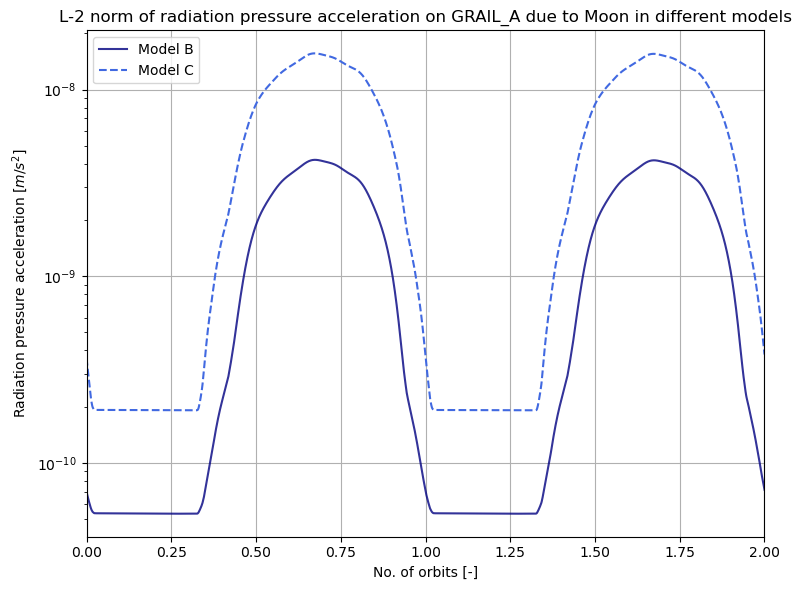

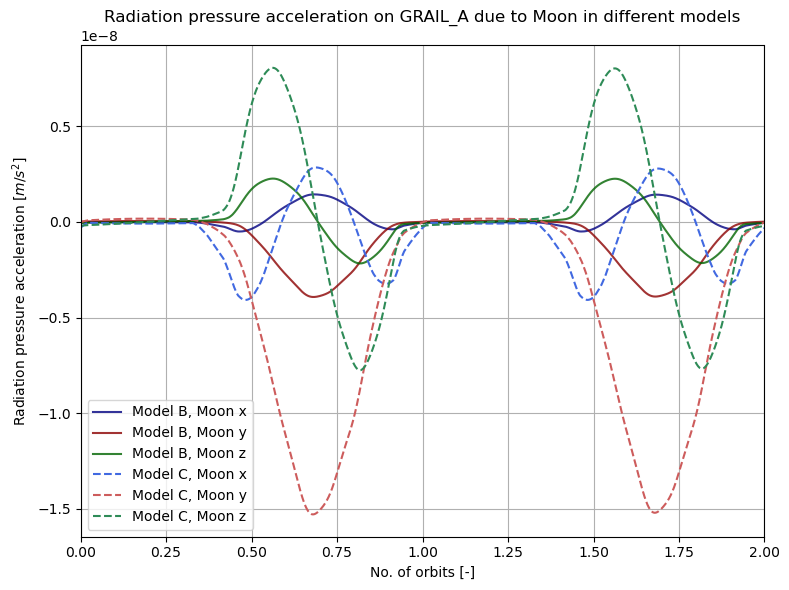

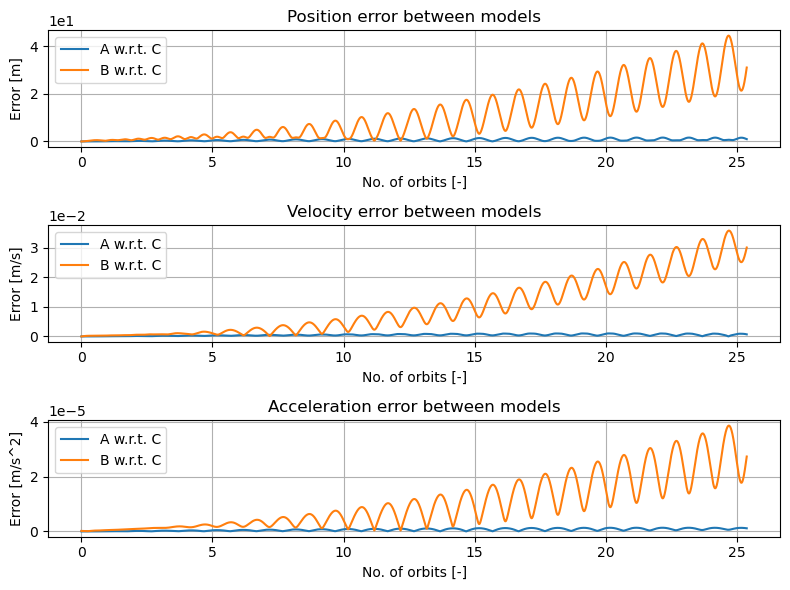

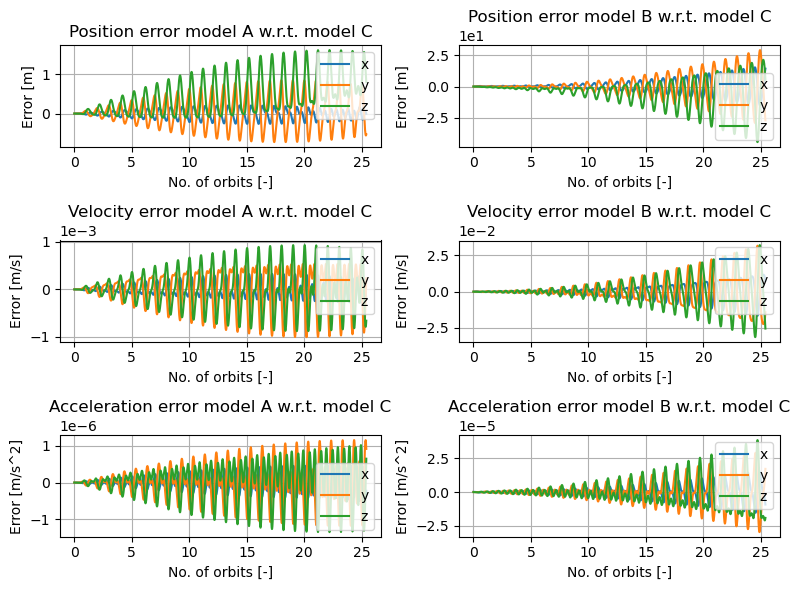

In [14]:

# extract the results from the dynamic simulators
states_A = result2array(dynamics_simulator_model_A.state_history)
states_B = result2array(dynamics_simulator_model_B.state_history)
states_C = result2array(dynamics_simulator_model_C.state_history)

dep_vars_A = result2array(dynamics_simulator_model_A.dependent_variable_history)
dep_vars_B = result2array(dynamics_simulator_model_B.dependent_variable_history)
dep_vars_C = result2array(dynamics_simulator_model_C.dependent_variable_history)


time_array = states_A[:, 0] - simulation_start_epoch

states_A_C = states_A - states_C
states_B_C = states_B - states_C

dep_vars_A_C = dep_vars_A[:, 0:4] - dep_vars_C[:, 0:4]
dep_vars_B_C = dep_vars_B[:, 0:4] - dep_vars_C[:, 0:4]

# use the keplerian state to calculate the orbital period
moon_gravitational_parameter = spice.get_body_gravitational_parameter("Moon")
keplerian_initial_state = element_conversion.cartesian_to_keplerian(initial_state, moon_gravitational_parameter)
orbital_period = 2 * np.pi * ( keplerian_initial_state[0]**3 / moon_gravitational_parameter ) ** (1/2)
no_orbits_array = time_array / orbital_period


plt.figure(figsize=(8, 6))

plt.plot(no_orbits_array, np.linalg.norm(dep_vars_B[:, 7:10], axis=1), label="Model B", color="navy", alpha=0.8)
plt.plot(no_orbits_array, np.linalg.norm(dep_vars_C[:, 7:10], axis=1), label="Model C", color="royalblue", ls="--")

plt.yscale("log")

plt.title("L-2 norm of radiation pressure acceleration on GRAIL_A due to Moon in different models")

plt.xlabel("No. of orbits [-]")
plt.ylabel(r"Radiation pressure acceleration [$m/s^2$]")
plt.grid()

plt.xlim(0, 2)
plt.tight_layout()

plt.legend()
plt.savefig("Norm of rad pressures.png")

plt.figure(figsize=(8, 6))

plt.plot(no_orbits_array, dep_vars_B[:, 7], label="Model B, Moon x", color="navy", alpha=0.8)
plt.plot(no_orbits_array, dep_vars_B[:, 8], label="Model B, Moon y", color="darkred", alpha=0.8)
plt.plot(no_orbits_array, dep_vars_B[:, 9], label="Model B, Moon z", color="darkgreen", alpha=0.8)


plt.plot(no_orbits_array, dep_vars_C[:, 7], label="Model C, Moon x", color="royalblue", ls="--")
plt.plot(no_orbits_array, dep_vars_C[:, 8], label="Model C, Moon y", color="indianred", ls="--")
plt.plot(no_orbits_array, dep_vars_C[:, 9], label="Model C, Moon z", color="seagreen", ls="--")

plt.title("Radiation pressure acceleration on GRAIL_A due to Moon in different models")

plt.xlim(0, 2)

plt.xlabel("No. of orbits [-]")
plt.ylabel(r"Radiation pressure acceleration [$m/s^2$]")
plt.grid()

plt.tight_layout()

plt.legend()


### pos vel accell

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
axs = axs.flatten()

axs[0].set_title("Position error between models")
axs[0].plot(no_orbits_array, np.linalg.norm(states_A_C[:, 1:4], axis=1), label="A w.r.t. C")
axs[0].plot(no_orbits_array, np.linalg.norm(states_B_C[:, 1:4], axis=1), label="B w.r.t. C")
axs[0].set_ylabel("Error [m]")

axs[1].set_title("Velocity error between models")
axs[1].plot(no_orbits_array, np.linalg.norm(states_A_C[:, 5:7], axis=1), label="A w.r.t. C")
axs[1].plot(no_orbits_array, np.linalg.norm(states_B_C[:, 4:7], axis=1), label="B w.r.t. C")
axs[1].set_ylabel("Error [m/s]")

axs[2].set_title("Acceleration error between models")
axs[2].plot(no_orbits_array, np.linalg.norm(dep_vars_A_C[:, 1:4], axis=1), label="A w.r.t. C")
axs[2].plot(no_orbits_array, np.linalg.norm(dep_vars_B_C[:, 1:4], axis=1), label="B w.r.t. C")
axs[2].set_ylabel("Error [m/s^2]")

for ax in axs:
    ax.legend()
    ax.set_xlabel("No. of orbits [-]")
    ax.grid()
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    
fig.tight_layout()



fig, axs = plt.subplots(3, 2, figsize=(8, 6))
axs = axs.flatten()

axs[0].set_title("Position error model A w.r.t. model C")
axs[0].plot(no_orbits_array, states_A_C[:, 1], label="x")
axs[0].plot(no_orbits_array, states_A_C[:, 2], label="y")
axs[0].plot(no_orbits_array, states_A_C[:, 3], label="z")
axs[0].set_ylabel("Error [m]")

axs[1].set_title("Position error model B w.r.t. model C")
axs[1].plot(no_orbits_array, states_B_C[:, 1], label="x")
axs[1].plot(no_orbits_array, states_B_C[:, 2], label="y")
axs[1].plot(no_orbits_array, states_B_C[:, 3], label="z")
axs[1].set_ylabel("Error [m]")

axs[2].set_title("Velocity error model A w.r.t. model C")
axs[2].plot(no_orbits_array, states_A_C[:, 4], label="x")
axs[2].plot(no_orbits_array, states_A_C[:, 5], label="y")
axs[2].plot(no_orbits_array, states_A_C[:, 6], label="z")
axs[2].set_ylabel("Error [m/s]")

axs[3].set_title("Velocity error model B w.r.t. model C")
axs[3].plot(no_orbits_array, states_B_C[:, 4], label="x")
axs[3].plot(no_orbits_array, states_B_C[:, 5], label="y")
axs[3].plot(no_orbits_array, states_B_C[:, 6], label="z")
axs[3].set_ylabel("Error [m/s]")

axs[4].set_title("Acceleration error model A w.r.t. model C")
axs[4].plot(no_orbits_array, dep_vars_A_C[:, 1], label="x")
axs[4].plot(no_orbits_array, dep_vars_A_C[:, 2], label="y")
axs[4].plot(no_orbits_array, dep_vars_A_C[:, 3], label="z")
axs[4].set_ylabel("Error [m/s^2]")

axs[5].set_title("Acceleration error model B w.r.t. model C")
axs[5].plot(no_orbits_array, dep_vars_B_C[:, 1], label="x")
axs[5].plot(no_orbits_array, dep_vars_B_C[:, 2], label="y")
axs[5].plot(no_orbits_array, dep_vars_B_C[:, 3], label="z")
axs[5].set_ylabel("Error [m/s^2]")

for ax in axs:
    ax.legend()
    ax.set_xlabel("No. of orbits [-]")
    ax.grid()
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    
fig.tight_layout()

